In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
import math
import seaborn as sns
import re
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_full = pd.concat([df_train, df_test], axis = 0)

First of all, we examine the dataset for missing values. We print out each column to get a feel for the incompleteness of the data.

In [3]:
print('Missing values per column:')
missing = pd.DataFrame()
for c in range(df_full.shape[1]):
    missing_count = df_full.iloc[:, c].shape[0] - df_full.iloc[:, c].count()  
    if missing_count > 0:
        print(f'{c}:\t{df_full.columns[c]}'
              f' - Missing: {missing_count}'
              f' - # Unique values: {len(df_full.iloc[:, c].value_counts())}')

Missing values per column:
3:	Alley - Missing: 2721 - # Unique values: 2
6:	BsmtCond - Missing: 82 - # Unique values: 4
7:	BsmtExposure - Missing: 82 - # Unique values: 4
8:	BsmtFinSF1 - Missing: 1 - # Unique values: 991
9:	BsmtFinSF2 - Missing: 1 - # Unique values: 272
10:	BsmtFinType1 - Missing: 79 - # Unique values: 6
11:	BsmtFinType2 - Missing: 80 - # Unique values: 6
12:	BsmtFullBath - Missing: 2 - # Unique values: 4
13:	BsmtHalfBath - Missing: 2 - # Unique values: 3
14:	BsmtQual - Missing: 81 - # Unique values: 4
15:	BsmtUnfSF - Missing: 1 - # Unique values: 1135
19:	Electrical - Missing: 1 - # Unique values: 5
23:	Exterior1st - Missing: 1 - # Unique values: 15
24:	Exterior2nd - Missing: 1 - # Unique values: 16
25:	Fence - Missing: 2348 - # Unique values: 4
26:	FireplaceQu - Missing: 1420 - # Unique values: 5
30:	Functional - Missing: 2 - # Unique values: 7
31:	GarageArea - Missing: 1 - # Unique values: 603
32:	GarageCars - Missing: 1 - # Unique values: 6
33:	GarageCond - Missing

45:	KitchenQual - Missing: 1 - # Unique values: 4
50:	LotFrontage - Missing: 486 - # Unique values: 128
54:	MSZoning - Missing: 4 - # Unique values: 5
55:	MasVnrArea - Missing: 23 - # Unique values: 444
56:	MasVnrType - Missing: 24 - # Unique values: 4
57:	MiscFeature - Missing: 2814 - # Unique values: 4
66:	PoolQC - Missing: 2909 - # Unique values: 3
70:	SalePrice - Missing: 1459 - # Unique values: 663
71:	SaleType - Missing: 1 - # Unique values: 9
75:	TotalBsmtSF - Missing: 1 - # Unique values: 1058
76:	Utilities - Missing: 2 - # Unique values: 2


There exists a lot of missing values. However, reading the data description, it's clear that the data is very clean and that the missing values are real values not incomplete data. We replace all np.nan values with a placeholder below. The placeholder is 'None' for discrete features or zero for continuous features. We also store the names of continuous and discrete features in order to plot them.

We define a continuous feature as any numerical feature with more than 15 unique values. The definition is entirely arbritrary but it serves its function.

In [4]:
missing_label = 'None'
cont_feature = []
disc_feature = []
for c in range(df_full.shape[1]):
    if len(pd.value_counts(df_full.iloc[:, c])) > 15 and df_full.iloc[:, c].values.dtype != 'object':
        if df_full.columns[c] not in ('SalePrice', 'Id'):
            df_full.iloc[:, c].fillna(0, inplace = True)
            cont_feature.append(df_full.columns[c])
    else:
        df_full.iloc[:, c].fillna(missing_label, inplace = True)
        disc_feature.append(df_full.columns[c])

Now we examine our response by plotting its histogram and QQ-plot.

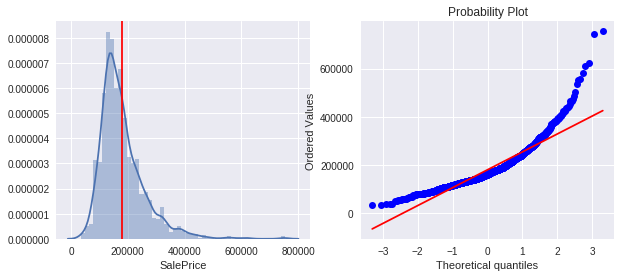

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
sns.distplot(df_train['SalePrice'], ax = ax[0])
ax[0].axvline(np.mean(df_train['SalePrice']), color = 'red')
stats.probplot(df_train['SalePrice'], plot = ax[1])
plt.show()

We can see from the histogram that our response exhibits positive skewness and positive kurtosis. We attempt to correct for that by applying a square root transformation.

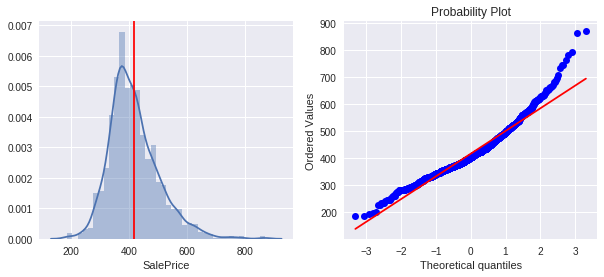

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
sns.distplot(np.sqrt(df_train['SalePrice']), ax = ax[0])
ax[0].axvline(np.mean(np.sqrt(df_train['SalePrice'])), color = 'red')
stats.probplot(np.sqrt(df_train['SalePrice']), plot = ax[1])
plt.show()

The data still exhibits some skewness and kurtosis. We now instead apply a natural log transformation.

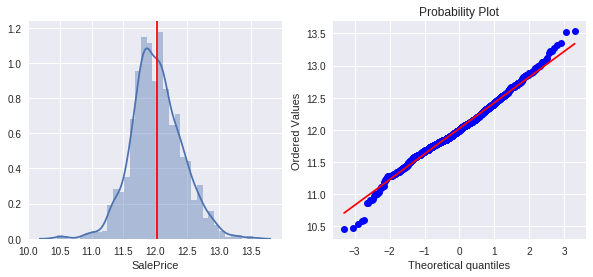

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
sns.distplot(np.log(df_train['SalePrice']), ax = ax[0])
ax[0].axvline(np.mean(np.log(df_train['SalePrice'])), color = 'red')
stats.probplot(np.log(df_train['SalePrice']), plot = ax[1])
plt.show()

The data is now approximately normal.

In [5]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
df_full['SalePrice'] = np.log(df_full['SalePrice'])

We then visualize the relation between each continuous feature and the target variable in order to get a better feel for the data.

/home/mmaesawy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


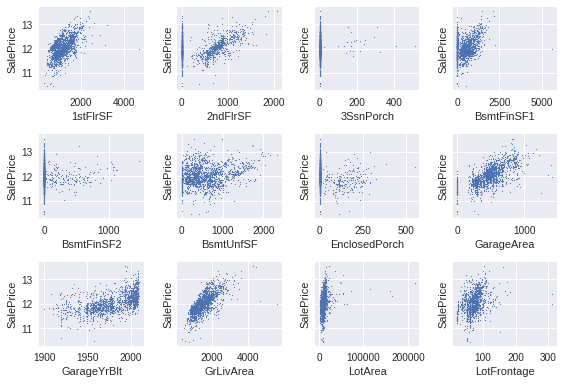

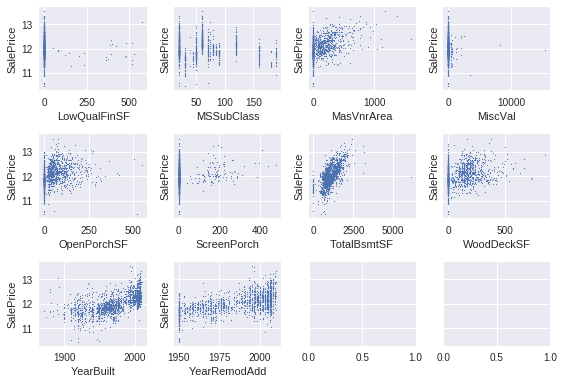

In [10]:
plt.ion()
i = 0
while i < len(cont_feature):
    fig, axs = plt.subplots(nrows = 3,
                            ncols= 4,
                            sharey = 'row')
    axs = axs.flatten()
    for ax in axs:
        if i >= len(cont_feature): break
        ax.scatter(x = df_train[cont_feature[i]],
                   y = df_train['SalePrice'],
                   s = 3, marker = '.')
        ax.set_xlabel(cont_feature[i])
        ax.set_ylabel('SalePrice')
        i += 1
    fig.tight_layout()
    fig.show()

We can see from the graphs that most continuous features can be well approximated by a linear function. Features that represent years can be even better approximated with a linear function after applying a transformation. We do the same for discrete features, plotting them in box plots to get a better feel for the data. We also convert the labels to numeric ordinal values. In addition, we move the MSSubClass feature to the discrete columns to sort it into ordinal values.

In [6]:
cont_feature.remove('MSSubClass')
disc_feature.append('MSSubClass')
i = 0
while i < len(disc_feature):
    fig, axs = plt.subplots(nrows = 2,
                            ncols= 5,
                            sharey = 'row',
                            figsize = (10, 4))
    axs = axs.flatten()
    for ax in axs:
        if i >= len(disc_feature): break
        categories = df_full[disc_feature[i]].value_counts().index.tolist()
        categories.sort(key = lambda x: df_full['SalePrice'][df_full[disc_feature[i]] == x].mean())
        t = df_full.iloc[:df_train.shape[0], :]
        boxes = [t['SalePrice'][t[disc_feature[i]] == category] for category in categories]
        ax.boxplot(boxes, labels=categories)
        ax.set_xlabel(disc_feature[i])
        ax.set_ylabel('SalePrice')
        
        # Transforming labels into ordinal values sorted according to mean (from above).
        categories = dict(zip(categories, range(len(categories))))
        df_full[disc_feature[i]] = df_full[disc_feature[i]].apply(lambda x: categories[x])
        i += 1
        
    fig.tight_layout()
    fig.show()
plt.show()

/home/mmaesawy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Once again, it appears that most features can be modelled with a linear function. We can conclude that a linear model will do well on this data, but we'll try different methods as well just to be sure. We standardize the data and prepare to initially model it without reducing its dimensionality to see how well it will do in its 'default' state.

In [7]:
random_seed = 4057585448 # Random seed for reproducibility.

df_train = df_full.iloc[:df_train.shape[0], :]
df_test = df_full.iloc[df_train.shape[0]:, :]

X_train = df_train.copy()[[x for x in df_train.columns if x not in ('SalePrice', 'Id')]].values
y_train = df_train.copy()['SalePrice'].values
X_test = df_test.copy()[[x for x in df_test.columns if x not in ('SalePrice', 'Id')]].values

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

We then test our default model and fit it with a Random Forest. Also, to get a reference for how well our model is doing, we calculate the train error we get if we simply predict the mean for each value in target variable. 

In [12]:
print('Default error:', math.sqrt(mean_squared_error(y_train, np.mean(y_train) * np.ones(y_train.shape))))

print("Grid searching RF model... ")
rf_gs = GridSearchCV(cv=5, n_jobs=-1, scoring="neg_mean_squared_error", verbose=0,
                      estimator=RandomForestRegressor(n_estimators = 100,
                                                       max_features='sqrt',
                                                       min_samples_split=5,
                                                       random_state=random_seed),
                      param_grid=[{'max_depth': [x for x in range(2, 50)]}])
rf_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-rf_gs.best_score_)}')
print(rf_gs.best_params_)

0.39931504624370256
Grid searching RF model... 


Best score is 0.13902371407979378
{'max_depth': 18}


Not bad, but we can do better.

We start by converting some categorical variables to dummy variables and standardizing our data.

In [8]:
cat_variables = ['LandContour',
                 'LotConfig',
                 'Neighborhood',
                 'Condition1',
                 'Condition2',
                 'RoofStyle',
                 'Exterior1st',
                 'Exterior2nd',
                 'Heating',
                 'GarageType',
                 'MiscFeature',
                 'SaleType',
                 'SaleCondition']

y_train = df_full['SalePrice'].values
df_full.drop(['SalePrice', 'Id'], axis = 1, inplace = True)

ohe = OneHotEncoder(categorical_features=[x in cat_variables for x in df_full.columns], sparse = False)
X = df_full.values.copy()
X = ohe.fit_transform(X)
cols = []
for i, c in enumerate(df_full.columns):
    if c in cat_variables:
        for j in range(len(np.unique(df_full[c]))):
            cols.append(c+str(j+1))
            cat_variables.append(c+str(j+1))
    else:
            cols.append(c)
df_full = pd.DataFrame(X)
df_full.columns = cols

df_train = df_full.iloc[:df_train.shape[0], :].copy()
df_test = df_full.iloc[df_train.shape[0]:, :].copy()

sc = StandardScaler()
df_train = pd.DataFrame(sc.fit_transform(df_train), columns = df_train.columns)
df_test = pd.DataFrame(sc.transform(df_test), columns = df_test.columns)
df_train = pd.concat([pd.DataFrame(y_train[:df_train.shape[0]], columns = ['SalePrice']), df_train], axis = 1) 
df_test = pd.concat([pd.DataFrame(y_train[df_train.shape[0]:], columns = ['SalePrice']), df_test], axis = 1)

Then we get rid of outliers in our data. We define an outlier as an observation with a Z-score greater than 4.0 in any column.

In [9]:
drop_indices = []
js = []
for i in range(df_train.shape[0]):
    for j in range(df_train.shape[1]):
        if math.fabs(df_train.iloc[i,j]) > 5.0\
                and df_train.columns[j] != 'SalePrice'\
                and df_train.columns[j] not in cat_variables:
            drop_indices.append(i)
            break
df_train.drop(drop_indices, axis = 0, inplace = True)
print(df_train.shape)


(1034, 191)




<p>Let's try to reduce our data's dimensionality. First, we plot a PCA scree plot to see how well we can do by simply projecting our data to a lower dimension.</p>

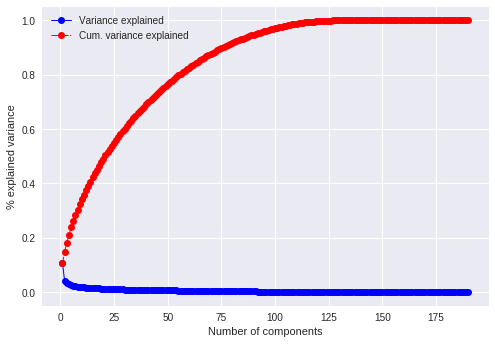

In [11]:
X_train = df_train[[x for x in df_train.columns if x != 'SalePrice']].values
pca = PCA(random_state = random_seed)
pca.fit(X_train)

plt.plot(range(1, X_train.shape[1] + 1),
         pca.explained_variance_ratio_,
         lw=1, color='blue',
         label='Variance explained',
         marker = 'o')
plt.plot(range(1, X_train.shape[1] + 1),
         np.cumsum(pca.explained_variance_ratio_),
         lw=1, color='red',
         ls='-.', marker = 'o',
         label='Cum. variance explained')
plt.xlabel('Number of components')
plt.ylabel('% explained variance')
plt.legend(loc = 'upper left')
plt.show()

<p>Due to the smoothness of the scree plot, we cannot use PCA to reduce our data's dimensionality (unless we simply use only the first component, ignoring over 80% of the information in our data).</p>

<p>To manually discard useless features, we compute the Fisher kurtosis of each feature and print them in a descending order to see which features have show low variability compared to others.</p>

In [12]:
print("Kurtosis for each feature: ")
kurts = [(c, df_train.columns[c], stats.kurtosis(df_train.iloc[:, c])) for c in range(df_train.shape[1])]
kurts.sort(key = lambda x: x[2], reverse = True)
for s in kurts:
    print(f'{s[0]}:\t{s[1]}: {s[2]}')

Kurtosis for each feature: 


31:	Condition25: 1029.0009680542137
85:	GarageType3: 1029.0009680542134
61:	Exterior2nd7: 1029.0009680542114
59:	Exterior2nd5: 1029.0009680542112
179:	SaleType8: 630.0900444724679
180:	SaleType9: 512.2250944234289
20:	Condition13: 512.0019379844961
123:	MiscFeature3: 512.0019379844956
105:	LandContour3: 512.0019379844953
71:	Exterior2nd17: 339.66957646298107
121:	MiscFeature1: 339.66957646298107
52:	Exterior1st14: 339.6695764629809
87:	GarageType5: 339.66957646298073
109:	LotConfig1: 253.50388349514571
60:	Exterior2nd6: 253.50388349514566
54:	Exterior1st16: 253.5038834951455
58:	Exterior2nd4: 253.50388349514537
181:	SaleType10: 249.24114979688895
127:	MoSold: 214.658180621389
48:	Exterior1st10: 201.8048590864917
42:	Exterior1st4: 201.8048590864916
103:	LandContour1: 124.25779727095511
165:	RoofStyle6: 112.34601410547512
98:	Heating6: 98.40976562500015
62:	Exterior2nd8: 98.40976562500012
112:	LotConfig4: 89.0107526881721
106:	LandContour4: 89.01075268817206
168:	SaleCondition3: 87.02461

We discard any feature which has a kurtosis of greater than 100.0

In [13]:
df_train = df_train.drop([s[1] for s in kurts if s[2] > 50 and s[1] != 'SalePrice'], axis = 1)
df_test = df_test.drop([s[1] for s in kurts if s[2] > 50 and s[1] != 'SalePrice'], axis = 1)
print(df_train.shape)

(1034, 158)


We display a heatmap to visualize the correlation between each feature.

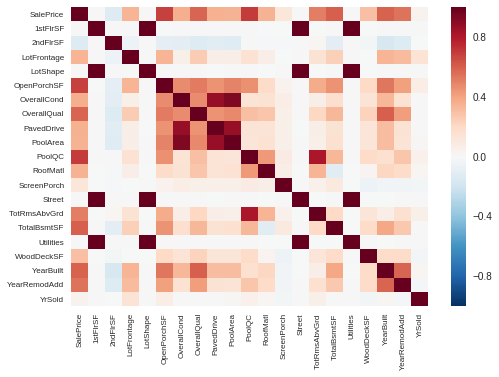

In [24]:
g = sns.heatmap(df_train[[x for x in df_train.columns if x not in cat_variables]].corr('pearson'))
g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=8)
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=8)
sns.plt.show()

In [23]:
drop_feat = set()
corr_matrix = df_train[[x for x in df_train.columns if x not in cat_variables]].corr('pearson')
for i in range(1, corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[1]):
        if math.fabs(corr_matrix.iloc[i, j]) > 0.7:
            drop_feat.add(df_train.columns[j])
df_train.drop(drop_feat, axis = 1, inplace = True)
df_test.drop(drop_feat, axis = 1, inplace = True)

We discard any feature that is heavily correlated with another, or is uncorrelated with any other feature. For example YrSold has low correlation with every other feature, including the target variable. And TotalBsmtSF is heavily correlated with 1stFloorSF, so we discard that too.

In [17]:
df_train = df_train.drop(['Exterior2nd', 'FireplaceQu', 'GarageCars', 'YrSold', 'GarageFinish', 'GarageQual', 'GarageYrBlt', 'TotalBsmtSF', 'GrLivArea', 'Fence', 'YrSold'], axis = 1)
df_test = df_test.drop(['Exterior2nd', 'FireplaceQu', 'GarageCars', 'YrSold', 'GarageFinish', 'GarageQual', 'GarageYrBlt', 'TotalBsmtSF', 'GrLivArea', 'Fence', 'YrSold'], axis = 1)

We then compute the correlation between the target feature and every other feature to study the importance of each feature in predicting the response.

In [25]:
corr = [(df_train.columns[c], df_train['SalePrice'].corr(df_train.iloc[:, c])) for c in range(df_train.shape[1])]
corr.sort(key = lambda x: x[1], reverse = True)
for c in corr:
    print(c)

('SalePrice', 1.0)
('SaleType6', 0.81430781067131508)
('PoolQC', 0.69685393410227126)
('OpenPorchSF', 0.68742808045823423)
('RoofStyle4', 0.66374400401393929)
('Neighborhood12', 0.65121589570700666)
('Neighborhood25', 0.65014609377998001)
('Neighborhood18', 0.64758247393206847)
('TotalBsmtSF', 0.59968341812394821)
('YearBuilt', 0.58715834200203676)
('OverallQual', 0.57957694744731947)
('Neighborhood23', 0.56898078919942308)
('YearRemodAdd', 0.54583862903991909)
('Neighborhood22', 0.53006336266835419)
('SaleCondition4', 0.52331463939202805)
('Neighborhood20', 0.5184346762259423)
('TotRmsAbvGrd', 0.51070839383119682)
('Neighborhood21', 0.45584068759948976)
('RoofStyle1', 0.43561375909366612)
('SaleType1', 0.4326131033427702)
('SaleType5', 0.40231886264426786)
('SaleCondition6', 0.39405380194038286)
('OverallCond', 0.3653593316709961)
('PavedDrive', 0.35683924341216894)
('SaleType4', 0.34941668639912904)
('PoolArea', 0.34921376397116255)
('RoofMatl', 0.34606637779523841)
('Neighborhood5',

We drop every feature that has an absolute correlation of less the 0.25 with that response.

In [26]:
df_train = df_train.drop([c[0] for c in corr if math.fabs(c[1]) < 0.25], axis = 1)
df_test = df_test.drop([c[0] for c in corr if math.fabs(c[1]) < 0.25], axis = 1)

In [27]:
print(df_train.shape)

(1034, 35)


Finally, we search for the best model that represents our data.

In [28]:
X_train = df_train.copy()[[x for x in df_train.columns if x not in ('SalePrice', 'Id')]].values
y_train = df_train.copy()['SalePrice'].values
X_test = df_test.copy()[[x for x in df_test.columns if x not in ('SalePrice', 'Id')]].values

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [30]:
print("Grid searching GB model...")
gb_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=GradientBoostingRegressor(random_state = random_seed),
                      param_grid=[{'learning_rate': [x / 100 for x in range(5, 20, 1)],
                                   'max_depth': [x for x in range(2, 7)],
                                   'max_features': [x / 10 for x in range(1, 11)]}])
gb_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-gb_gs.best_score_)}')
print(gb_gs.best_params_)
print()

print("Grid searching AB model...")
ad_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=AdaBoostRegressor(base_estimator=LinearRegression(),
                                                  random_state=random_seed),
                      param_grid=[{'learning_rate': [x / 100 for x in range(85, 115, 1)]}])
ad_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-ad_gs.best_score_)}')
print(ad_gs.best_params_)
print()

print("Grid searching bagging model...")
bag_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=BaggingRegressor(base_estimator = LinearRegression(),
                                                 n_estimators = 25),
                      param_grid=[{'max_features': [x / 100 for x in range(50, 101, 1)]}])
bag_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-bag_gs.best_score_)}')
print(bag_gs.best_params_)
print()

print("Grid searching RF model... ")
rf_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=RandomForestRegressor(n_estimators = 100,
                                                       max_features='sqrt',
                                                       min_samples_split=5,
                                                       random_state=random_seed),
                      param_grid=[{'max_depth': [x for x in range(2, 50)]}])
rf_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-rf_gs.best_score_)}')
print(rf_gs.best_params_)

print("Grid searching KNN model... ")
knn_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=KNeighborsRegressor(),
                      param_grid=[{'n_neighbors': [x for x in range(3, 80)],
                                   'weights': ['uniform', 'distance']}])
knn_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-knn_gs.best_score_)}')
print(knn_gs.best_params_)

print("Grid searching lasso model...")
lasso_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Lasso(max_iter = 10**5),
                      param_grid=[{'alpha': [x / 10000 for x in range(10, 1000, 1)]}])
lasso_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-lasso_gs.best_score_)}')
print(lasso_gs.best_params_)
print()

print("Grid searching ridge model...")
ridge_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Ridge(max_iter = 10**5),
                      param_grid=[{'alpha': [x / 10 for x in range(0, 150, 2)]}])
ridge_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-ridge_gs.best_score_)}')
print(ridge_gs.best_params_)
print()

Grid searching GB model...


Best score is 0.11936504215136136
{'learning_rate': 0.15, 'max_depth': 2, 'max_features': 0.6}

Grid searching AB model...


Best score is 0.13860025036780207
{'learning_rate': 1.05}

Grid searching bagging model...


Best score is 0.12514521323406586
{'max_features': 0.94}

Grid searching RF model... 


Best score is 0.13372119058080567
{'max_depth': 13}
Grid searching KNN model... 


Best score is 0.15548749629845934
{'n_neighbors': 8, 'weights': 'distance'}
Grid searching lasso model...


Best score is 0.12614793374203095
{'alpha': 0.0021}

Grid searching ridge model...


Best score is 0.12549726300555256
{'alpha': 14.8}



Evidently, the best model is a gradient boosting model with a learning rate of 0.09, max depth of 4, and max features of 0.3. We search further around these parameters to get an even better model.

In [31]:
print("Grid searching lasso model...")
lasso_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Lasso(max_iter = 10**5),
                      param_grid=[{'alpha': [x / 10000 for x in range(10, 1000, 1)]}])
lasso_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-lasso_gs.best_score_)}')
print(lasso_gs.best_params_)
print()

print("Grid searching ridge model...")
ridge_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Ridge(max_iter = 10**5),
                      param_grid=[{'alpha': [x / 10 for x in range(130, 170, 2)]}])
ridge_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-ridge_gs.best_score_)}')
print(ridge_gs.best_params_)
print()

print("Grid searching GB model...")
gb_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=GradientBoostingRegressor(random_state = random_seed),
                      param_grid=[{'learning_rate': [x/1000 for x in range(125, 175, 1)],
                                   'max_features': [x / 100 for x in range(60, 70)],
                                   'max_depth': [1, 2]}])
gb_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-gb_gs.best_score_)}')
print(gb_gs.best_params_)
print()

Grid searching lasso model...


Best score is 0.12614793374203095
{'alpha': 0.0021}

Grid searching ridge model...


Best score is 0.12548875841177884
{'alpha': 16.8}

Grid searching GB model...


Best score is 0.1191640551318332
{'learning_rate': 0.169, 'max_depth': 2, 'max_features': 0.6}



So now that we know our optimal hyperparameters, we train the model on the full dataset, predict the target using the test data, and output them to a .csv file.

In [32]:
gb = gb_gs.best_estimator_
gb.fit(X_train, y_train)
y_pred = np.exp(gb.predict(X_test))
output = pd.concat([pd.read_csv('test.csv')['Id'], pd.Series(y_pred)], axis = 1)
output.columns = ['Id', 'SalePrice']
output.to_csv('submissions.csv', index = False)